# Lake-size distribution (LSD) scale comparison.

Goal: to load lake maps from the same region at two scale (HR and LR) and predict the small water body coverage (defined as area < 0.001 or 0.01 km2) from the LR dataset and physiographic region (with uncertainty).

Steps:
1. plot both LSD as survivor functions in log-log space (see functions from TGRS paper)

In [1]:
import os
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as colorsa
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage as ndi 
from scipy.io import loadmat
from scipy.stats import binned_statistic
import pandas as pd
import geopandas as gpd
import pyogrio
import powerlaw
from tqdm import tqdm
from LSD import LSD, BinnedLSD, plotECDFByValue, plotEPDFByValue
## Plotting style
# plt.style.use('/mnt/c/Users/ekyzivat/Dropbox/Python/Matplotlib-rcParams/presentation.mplstyle')
# %matplotlib inline

## Plotting params
sns.set_theme('notebook', font='Ariel')
sns.set_style('ticks')


In [2]:
## I/O

## BAWLD domain
dataset = 'HL'
roi_region = 'BAWLD'
gdf_bawld_pth = '/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip'
gdf_HL_jn_pth = '/mnt/g/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.shp' # HL clipped to BAWLD
version=3

## BAWLD-NAHL domain
# dataset = 'HL'
# roi_region = 'WBD_BAWLD'
# gdf_bawld_pth = '/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/edk_out/BAWLD_V1_clipped_to_WBD.shp'
# gdf_HL_jn_pth = '/mnt/g/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD_roiNAHL.shp' # HL clipped to BAWLD and WBD
# version=1

## dynamic vars
analysis_dir = os.path.join('/mnt/g/Ch4/Area_extrapolations','v'+str(version))
area_extrap_pth = os.path.join(analysis_dir, dataset+'_sub'+roi_region+'_extrap.csv')
os.makedirs(analysis_dir, exist_ok=True)


## Functions and classes

### Plotting functions

In [3]:
def findNearest(arr, val):
    ''' Function to find index of value nearest to target value'''
    # calculate the difference array
    difference_array = np.absolute(arr-val)
    
    # find the index of minimum element from the array
    index = difference_array.argmin()
    return index

# PeRL data exploration

In [4]:
# Inputs
perl_landscape_pth = '/mnt/f/PeRL/PeRL_permafrost_landscapes/PeRL_perma_land.shp'

In [5]:
df_perl_ls = pyogrio.read_dataframe(perl_landscape_pth, read_geometry=True, use_arrow=True) # NOTE these following params apply to pandas:, dtype = {'frac_re': float}, na_values='NA') #, na_values='NA')
df_perl_ls.dropna(inplace=True) # dropping rows with no pond estimation - still keeps some regions with fraction data but no confidence intervals - comment out if using as a spatial index to load regional lake maps

## Clean up formatting for summary stats parsing
for var in ['frac_re', 'dens_re','dens_po_re', 'frac_po_re']:
    df_perl_ls[var] = pd.to_numeric(df_perl_ls[var],errors = 'coerce')
df_perl_ls.replace('NA',np.NaN, inplace=True)

## Add stat for ponds as fraction of water bodies
df_perl_ls['frac_ponds_norm'] = df_perl_ls.frac_ponds / df_perl_ls.frac * 100

## Describ
df_perl_ls.describe()
# df_perl_ls.info()
# df_perl_ls.dens_re

,PERMID,ECOZID,AREA,PERIMETER,confidence,frac,frac_re,dens,dens_re,frac_ponds,dens_ponds,dens_po_re,frac_po_re,area_km2,frac_ponds_norm
count,9.000000e+01,90.000000,9.000000e+01,9.000000e+01,90.000000,90.000000,56.000000,90.000000,56.000000,90.000000,90.000000,56.000000,56.000000,90.000000,90.000000
mean,1.720005e+08,167.788889,1.760757e+10,2.464504e+06,1.622222,7.745196,9.271695,13.054049,14.871469,1.118476,12.234809,16.428462,11.948254,17607.570278,15.180540
std,7.600753e+07,79.958767,3.173236e+10,3.644236e+06,0.487548,3.984106,7.506312,13.616041,16.737072,1.008503,13.507027,17.699687,10.748142,31732.362649,13.226395
min,1.003901e+08,102.000000,9.206387e+04,1.700568e+03,1.000000,1.082965,1.404741,0.967059,1.711065,0.043382,0.722353,1.227089,1.715034,0.092000,0.811064
25%,1.227674e+08,112.000000,1.255820e+09,3.940341e+05,1.000000,4.966632,3.849780,2.870042,3.409839,0.380385,2.307509,3.775760,3.289065,1255.820250,7.545870
50%,1.307571e+08,123.000000,5.737036e+09,1.255623e+06,2.000000,7.053175,5.748016,6.962368,7.596801,0.764033,5.619739,9.314350,5.482510,5737.036000,10.437574
75%,2.113740e+08,211.750000,1.870556e+10,3.456383e+06,2.000000,9.899185,11.837370,23.080014,18.855585,1.553638,22.045021,21.548837,16.443220,18705.563750,21.225034
max,3.080753e+08,307.000000,1.996447e+11,2.902694e+07,2.000000,21.107333,28.139881,57.045118,53.156887,5.880267,56.670111,55.856056,32.925706,199644.706000,56.612255


In [6]:
## Area-weighted pond fraction
np.average(df_perl_ls.dropna().frac_ponds_norm, weights=df_perl_ls.dropna().AREA)

10.058448037452003

(0.0, 25.0)

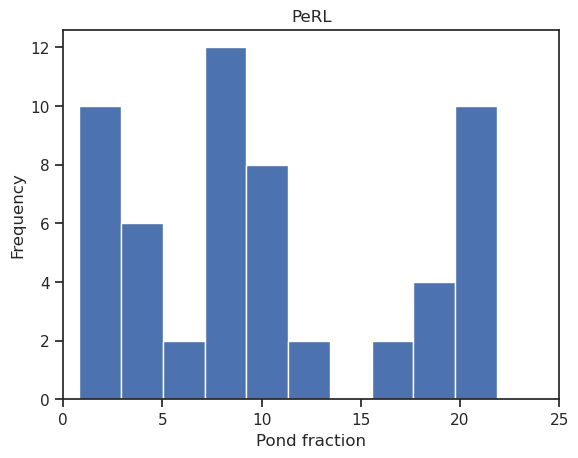

In [7]:
df_perl_ls.dropna().frac_ponds_norm.plot.hist()
plt.title('PeRL')
plt.xlabel('Pond fraction')
plt.xlim([0, 25])

# Loading PeRL LSD

In [8]:
## Load in serial with my custom class (can be parallelized with multiprocessing Pool.map). Help from ChatGPT

# Define the file pattern
file_pattern = '/mnt/f/PeRL/PeRL_waterbodymaps/waterbodies/*.shp'
shapefiles = glob(file_pattern)

# create an empty list to store the loaded shapefiles
dfs = []

# loop through the shapefiles and load each one using Geopandas
for shpfile in shapefiles:
    try: # in case some regions have lakes with 0 area
        lsd = LSD.from_shapefile(shpfile, area_var='AREA', region_var=None, idx_var=None, name=os.path.basename(shpfile).replace('.shp','')) # gpd.read_file(shpfile, engine='pyogrio')
        dfs.append(lsd)
    except:
        pass

# merge all the loaded shapefiles into a single GeoDataFrame
lsd_perl = LSD.concat(dfs, ignore_index=True) #, crs=gdfs[0].crs)
lsd_perl.head(2)


,index,Area_km2,Region
0,0,12626.366589,abi0012010xxxx_ortho_nplaea
1,1,9027.993008,abi0012010xxxx_ortho_nplaea


<AxesSubplot:xlabel='Lake area ($km^2$)', ylabel='Cumulative fraction of total area'>

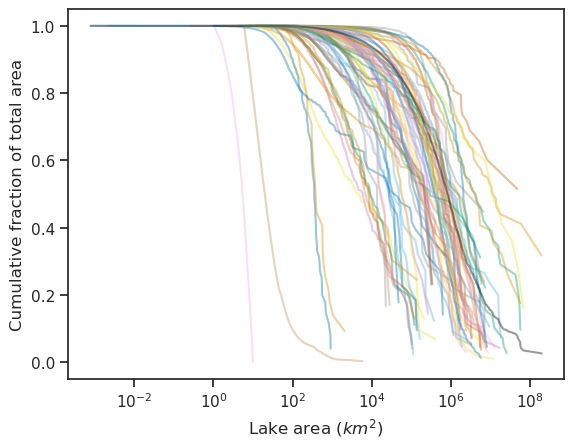

In [9]:
## plot
lsd_perl.plot_lsd(plotLegend=False)

In [10]:
type(lsd_perl)

LSD.LSD

# CIR LSD analysis

In [11]:
## Inputs
lsd_cir_pth = '/mnt/g/Planet-SR-2/Classification/cir/dcs_fused_hydroLakes_buf_10_sum.shp'
gdf_cir_lsd = pyogrio.read_dataframe(lsd_cir_pth, read_geometry=True, use_arrow=True)
gdf_cir_lsd.head()


,Join_Count,TARGET_FID,Area,RiverDomin,Category4,Region4,OID_,JOIN_FID,geometry
0,1,0,0.011819,0,1,12,1,0,"POLYGON ((-680953.719 1387817.517, -680953.420..."
1,1,1,0.006978,0,1,12,2,1,"POLYGON ((-681991.719 1387821.517, -681991.402..."
2,1,2,0.259890,0,1,12,3,2,"POLYGON ((-681504.361 1387932.796, -681503.668..."
3,1,3,0.001193,0,1,12,4,3,"POLYGON ((-680021.532 1387963.352, -680021.908..."
4,1,4,0.001669,0,1,12,5,4,"POLYGON ((-681108.187 1388031.354, -681108.719..."


In [12]:
# gdf_cir_lsd.info()
gdf_cir_lsd.head(2)

,Join_Count,TARGET_FID,Area,RiverDomin,Category4,Region4,OID_,JOIN_FID,geometry
0,1,0,0.011819,0,1,12,1,0,"POLYGON ((-680953.719 1387817.517, -680953.420..."
1,1,1,0.006978,0,1,12,2,1,"POLYGON ((-681991.719 1387821.517, -681991.402..."


In [13]:
## Add region to gdf
regions = ['Sagavanirktok River', 'Yukon Flats Basin', 'Old Crow Flats', 'Mackenzie River Delta', 'Mackenzie River Valley', 'Canadian Shield Margin', 'Canadian Shield', 'Slave River', 'Peace-Athabasca Delta', 'Athabasca River', 'Prairie Potholes North', 'Prairie Potholes South', 'Tuktoyaktuk Peninsula', 'All']
# gdf_cir_lsd['Region'] = regions[gdf_cir_lsd['Region4']-2]
# gdf_cir_lsd.apply(Region = lambda x: x.Region4, axis=1) # (regions[x['Region4']-2]) # regions[x.Region4]
# gdf_cir_lsd['Region'].head()
for idx in gdf_cir_lsd.index: # slow, non-vectorized way...
    gdf_cir_lsd.loc[idx, 'Region'] = regions[gdf_cir_lsd.loc[idx, 'Region4']-2]
gdf_cir_lsd.head()

,Join_Count,TARGET_FID,Area,RiverDomin,Category4,Region4,OID_,JOIN_FID,geometry,Region
0,1,0,0.011819,0,1,12,1,0,"POLYGON ((-680953.719 1387817.517, -680953.420...",Prairie Potholes North
1,1,1,0.006978,0,1,12,2,1,"POLYGON ((-681991.719 1387821.517, -681991.402...",Prairie Potholes North
2,1,2,0.259890,0,1,12,3,2,"POLYGON ((-681504.361 1387932.796, -681503.668...",Prairie Potholes North
3,1,3,0.001193,0,1,12,4,3,"POLYGON ((-680021.532 1387963.352, -680021.908...",Prairie Potholes North
4,1,4,0.001669,0,1,12,5,4,"POLYGON ((-681108.187 1388031.354, -681108.719...",Prairie Potholes North


In [14]:
## Cycle through 14 regions and compute additional stats
df_cir_rec = pd.DataFrame(columns = ['Region_ID', 'Region', 'Lake_area', 'stat', 'A_0.001', 'A_0.001_cor', 'A_0.01_cor', 'A_0.01', 'A_g100m', 'A_g1', 'PeRL_pnd_f']) # cir recomputed, for double checking A_0.001 from paper; A_0.001_cor excludes the largest lakes like in PeRL, but uses native CIR min size of 40 m2; computing A_0.01 analogous to PeRL pond fraction, PeRL_pnd for equivalent to perl analysis (min is 100 m2, max is 1 km2), A_g100m, for lakes > 100 m2, analogous to PeRL, F_g1 for area of lakes larger than PeRL maximum size, 'PeRL_all' to simulate perl size domain, and 'PeRL_pnd_f' which is perl pond divided perl all # 'PeRL_pnd', 'PeRL_all'
for i, region in enumerate(range(2, 16)): # no region 1
    if region!=15: 
        gdf_tmp = gdf_cir_lsd.query('Region4 == @region')
    else:
        gdf_tmp = gdf_cir_lsd # compute over all
    df_cir_rec.loc[i, 'Region_ID'] = region
    df_cir_rec.loc[i, 'Region'] = regions[i]
    df_cir_rec.loc[i, 'Lake_area'] = gdf_tmp.Area.sum()
    df_cir_rec.loc[i, 'A_0.001'] = gdf_tmp.query('(Area < 0.001)').Area.sum() / df_cir_rec.loc[i, 'Lake_area'] * 100
    df_cir_rec.loc[i, 'A_0.001_cor'] = gdf_tmp.query('(Area < 0.001)').Area.sum() / gdf_tmp.query('(Area < 1)').Area.sum() * 100
    df_cir_rec.loc[i, 'A_0.01_cor'] = gdf_tmp.query('(Area < 0.01)').Area.sum() / gdf_tmp.query('(Area < 1)').Area.sum() * 100
    df_cir_rec.loc[i, 'A_0.01'] = gdf_tmp.query('(Area < 0.01)').Area.sum() / df_cir_rec.loc[i, 'Lake_area'] * 100
    df_cir_rec.loc[i, 'A_g1'] = gdf_tmp.query('(Area >= 1)').Area.sum() / df_cir_rec.loc[i, 'Lake_area'] * 100    
    df_cir_rec.loc[i, 'A_g100m'] = gdf_tmp.query('(Area >= 0.0001)').Area.sum() / df_cir_rec.loc[i, 'Lake_area'] * 100
    df_cir_rec.loc[i, 'PeRL_pnd_f'] = gdf_tmp.query('(Area >= 0.0001) and  (Area < 0.01)').Area.sum() / \
         gdf_tmp.query('(Area >= 0.0001) and  (Area < 1)').Area.sum() * 100
    df_cir_rec.loc[i, 'HL_pnd_f_4'] = gdf_tmp.query('(Area >= 0.0001) and  (Area < 0.1)').Area.sum() / \
        gdf_tmp.query('(Area >= 0.0001) and  (Area < 1)').Area.sum() * 100 # Pond fraction, as defined by HydroLakes lower limit and upper limit defined by CIR # 4 means that lower limit is 10^-4
    df_cir_rec.loc[i, 'HL_pnd_r_4'] = gdf_tmp.query('(Area >= 0.0001) and  (Area < 0.1)').Area.sum() / \
        gdf_tmp.query('(Area >= 0.1) and  (Area < 1)').Area.sum() * 100 # Pond fraction, as defined by HydroLakes lower limit and upper limit defined by CIR (fraction, not ratio, so it can be used as divident for extrapolation from mid lakes)
    df_cir_rec.loc[i, 'HL_pnd_r_3'] = gdf_tmp.query('(Area >= 0.001) and  (Area < 0.1)').Area.sum() / \
        gdf_tmp.query('(Area >= 0.1) and  (Area < 1)').Area.sum() * 100 # to compare to WBD
    df_cir_rec.loc[i, 'HL_pnd_r_2'] = gdf_tmp.query('(Area >= 0.01) and  (Area < 0.1)').Area.sum() / \
        gdf_tmp.query('(Area >= 0.1) and  (Area < 1)').Area.sum() * 100 # to compare to Sheng

## Re-index
df_cir_rec.set_index('Region', inplace=True)

## View
df_cir_rec[['A_0.001_cor', 'A_0.01', 'A_0.01_cor', 'PeRL_pnd_f', 'HL_pnd_r_4', 'HL_pnd_r_3', 'HL_pnd_r_2']]

,A_0.001_cor,A_0.01,A_0.01_cor,PeRL_pnd_f,HL_pnd_r_4,HL_pnd_r_3,HL_pnd_r_2
Region,,,,,,,
Sagavanirktok River,3.031203,10.395833,10.395833,10.185303,47.667000,43.527349,32.626669
Yukon Flats Basin,0.99283,5.839131,7.522919,7.472215,59.048881,57.556135,47.164407
Old Crow Flats,0.195526,0.654397,1.837864,1.825564,23.633221,23.406948,21.376218
Mackenzie River Delta,0.396733,2.067478,3.93086,3.907932,29.847743,29.363461,24.773382
Mackenzie River Valley,0.863484,1.176034,6.227916,6.160738,46.737951,45.575106,37.697809
Canadian Shield Margin,1.33229,0.197271,8.305,8.246269,48.053952,46.175011,35.845026
Canadian Shield,0.247682,0.191295,2.25814,2.239487,31.176905,30.876975,28.239215
Slave River,4.147409,17.321269,23.358883,23.093916,94.104852,86.697767,49.278441
Peace-Athabasca Delta,2.832858,1.03603,13.606928,13.368182,60.758854,56.636452,39.268317


Median pond fraction for CIR: 6.8164765870156145



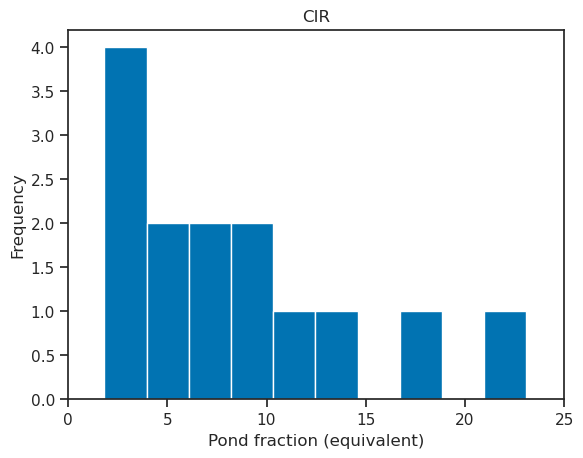

In [15]:
## CIR hist and calculate median pond fractions
df_cir_rec.PeRL_pnd_f.plot.hist()
plt.title('CIR')
plt.xlabel('Pond fraction (equivalent)')
plt.xlim([0, 25])
perl_pond_frac_cir = df_cir_rec.PeRL_pnd_f.median()
print(f'Median pond fraction for CIR: {perl_pond_frac_cir}')
# hl_pond_frac_cir = df_cir_rec.HL_pnd_f.median()
# print(f'Median HL pond fraction for CIR: {hl_pond_frac_cir}')
print('')

## CDF plots

### Plots

<AxesSubplot:xlabel='Area', ylabel='Density'>

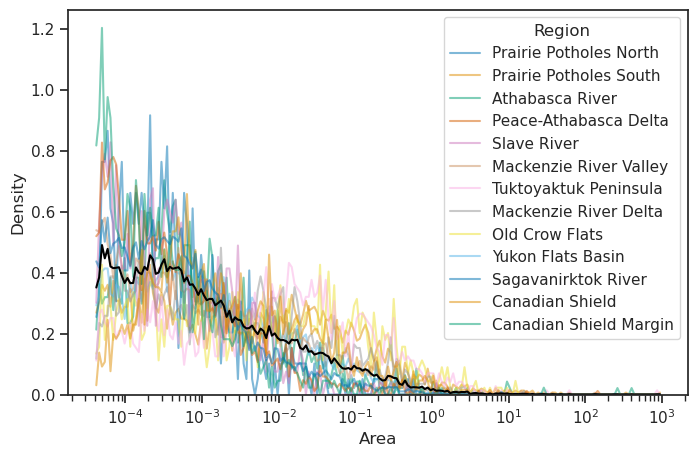

In [16]:
## Binned PDF plot (V1)
fig, ax = plt.subplots(figsize=(8,5)) # size=(5,3)
sns.histplot(data=gdf_cir_lsd, x="Area", hue="Region", element="poly", log_scale=True, bins=200, palette=None, stat='density', cumulative=False, common_norm=False, fill=False, alpha=0.5, ax=ax) # 
sns.histplot(data=gdf_cir_lsd, x="Area", color='black', element="poly", log_scale=True, bins=200, palette=None, stat='density', cumulative=False, common_norm=False, fill=False, ax=ax, label='All') # 
# ax.set_yscale('log')

Text(0.5, 0, 'Lake area')

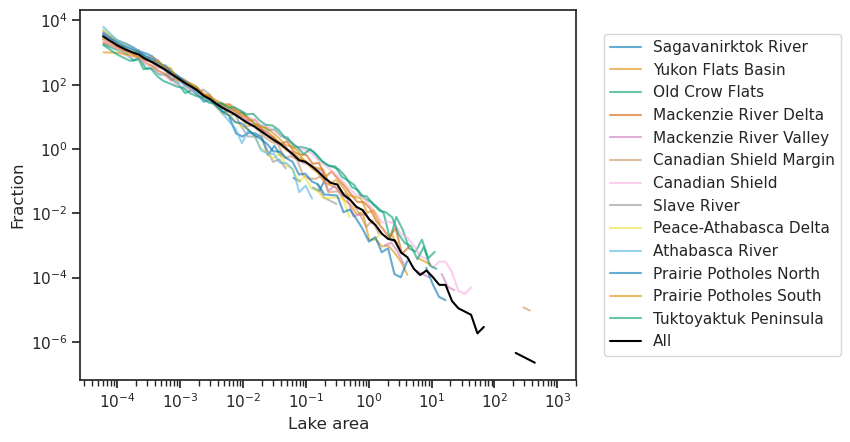

In [17]:
## PDF v2: Powerlaw package plots:  PDF (no binning)

## colors
# rainbow_cycler = cycler
sns.set_palette("colorblind",len(regions) ) # colors from https://stackoverflow.com/a/46152327/7690975 Other option is: `from cycler import cycler; `# ax.set_prop_cycle(rainbow_cycler), plt(... prop_cycle=rainbow_cycler, )

## plot
fig, ax = plt.subplots() # figsize=(5,3)
for region in regions[:-1]:
    powerlaw.plot_pdf(gdf_cir_lsd.query('Region == @region').Area, alpha=0.6, ax=ax, label=region) # color='green' # 

powerlaw.plot_pdf(gdf_cir_lsd.Area, ax=ax, color='black', label='All')
ax.legend(loc= 'center left', bbox_to_anchor=(1.04, 0.5)) # legend on right (see https://stackoverflow.com/a/43439132/7690975)
ax.set_ylabel('Fraction')
ax.set_xlabel('Lake area')

<AxesSubplot:xlabel='Area', ylabel='Probability'>

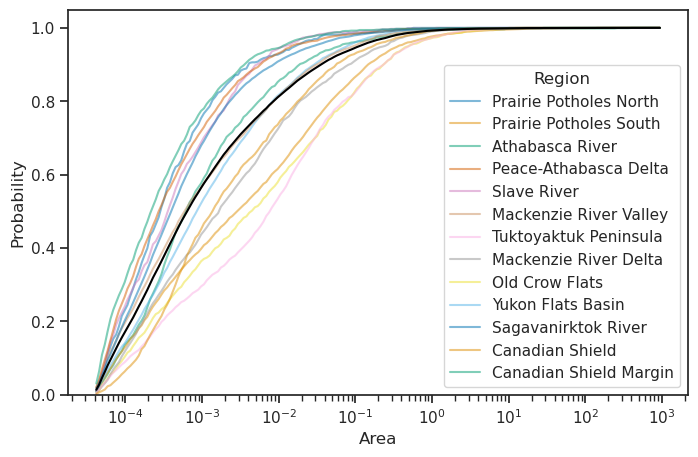

In [18]:
## Binned CDF plot
fig, ax = plt.subplots(figsize=(8,5)) # size=(5,3)
sns.histplot(data=gdf_cir_lsd, x="Area", hue="Region", element="poly", log_scale=True, bins=200, palette=None, stat='probability', cumulative=True, common_norm=False, fill=False, alpha=0.5, ax=ax) # 
sns.histplot(data=gdf_cir_lsd, x="Area", color='black', element="poly", log_scale=True, bins=200, palette=None, stat='probability', cumulative=True, common_norm=False, fill=False, ax=ax, label='All') # 
# ax.set_yscale('log')

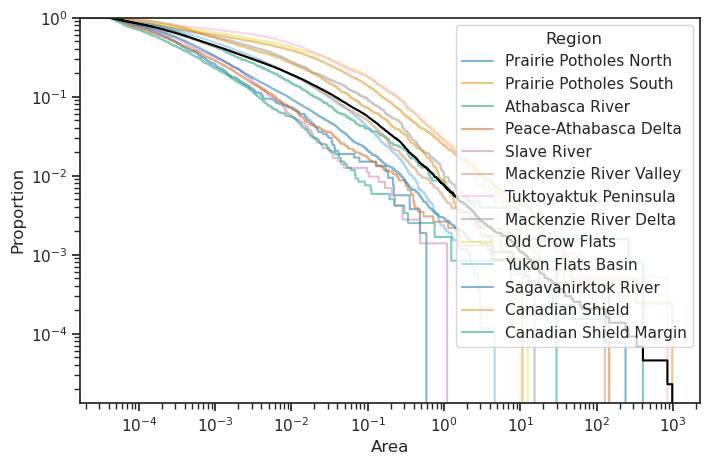

In [19]:
## Non-binned Empirical CDF plot (sns says downside is "basic properties of the distribution (such as its central tendency, variance, and the presence of any bimodality) may not be as intuitive.")
fig, ax = plt.subplots(figsize=(8,5)) # size=(5,3)
sns.ecdfplot(data=gdf_cir_lsd, complementary=True, x="Area", hue="Region", log_scale=True, alpha=0.5, ax=ax) # 
sns.ecdfplot(data=gdf_cir_lsd, complementary=True, x="Area", color='black', log_scale=True, ax=ax, label='All') # 
ax.set_yscale('log')

Text(0.5, 0, 'Lake area')

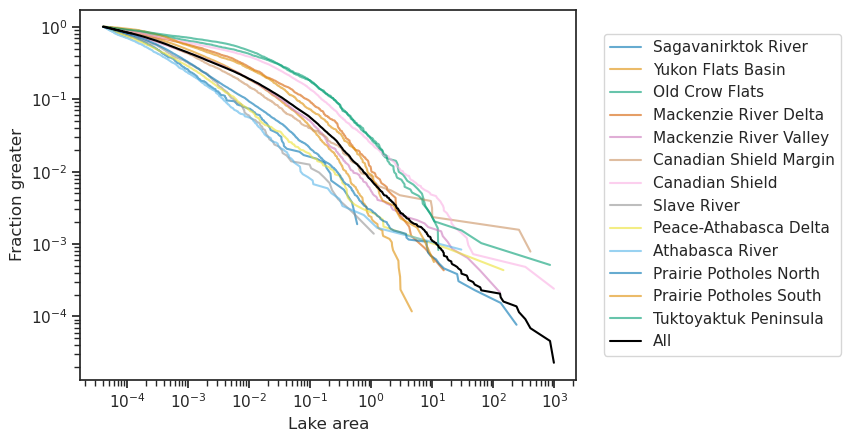

In [20]:
## Powerlaw package plots: CDF also doesn't use binning and no annoying step plot

## colors
# rainbow_cycler = cycler
sns.set_palette("colorblind",len(regions) ) # colors from https://stackoverflow.com/a/46152327/7690975 Other option is: `from cycler import cycler; `# ax.set_prop_cycle(rainbow_cycler), plt(... prop_cycle=rainbow_cycler, )

## plot
fig, ax = plt.subplots() # figsize=(5,3)
for region in regions[:-1]:
    powerlaw.plot_cdf(gdf_cir_lsd.query('Region == @region').Area, alpha=0.6, survival=True, ax=ax, label=region) # color='green' # 

powerlaw.plot_cdf(gdf_cir_lsd.Area, survival=True, ax=ax, color='black', label='All')
ax.legend(loc= 'center left', bbox_to_anchor=(1.04, 0.5)) # legend on right (see https://stackoverflow.com/a/43439132/7690975)
ax.set_ylabel('Fraction greater')
ax.set_xlabel('Lake area')

Text(0.5, 0, 'Lake area')

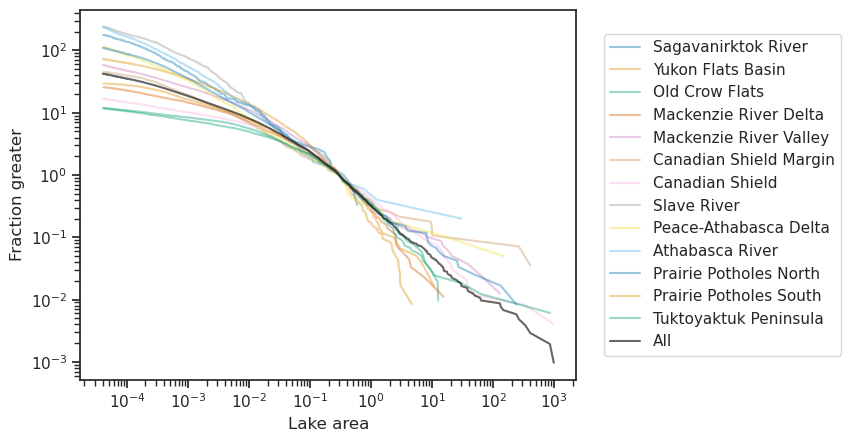

In [21]:
## Repeat, but apply offset based on value at 0.3 km2 to match up on high end

## colors
# rainbow_cycler = cycler
sns.set_palette("colorblind",len(regions) ) # colors from https://stackoverflow.com/a/46152327/7690975 Other option is: `from cycler import cycler; `# ax.set_prop_cycle(rainbow_cycler), plt(... prop_cycle=rainbow_cycler, )

## plot
fig, ax = plt.subplots() # figsize=(5,3)
for region in regions[:-1]:
    X, P = powerlaw.cdf(gdf_cir_lsd.query('Region == @region').Area, survival=True) # color='green' # 
    idx = findNearest(X, 0.3)
    ax.plot(X, P/(P[idx]), alpha=0.4, label=region)

## repeat for all (should re-use as function...)
X, P = powerlaw.cdf(gdf_cir_lsd.Area, survival=True)
idx = findNearest(X, 0.3)
ax.plot(X, P/(P[idx]), alpha=0.6, color='black', label='All')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc= 'center left', bbox_to_anchor=(1.04, 0.5)) # legend on right (see https://stackoverflow.com/a/43439132/7690975)
ax.set_ylabel('Fraction greater')
ax.set_xlabel('Lake area')

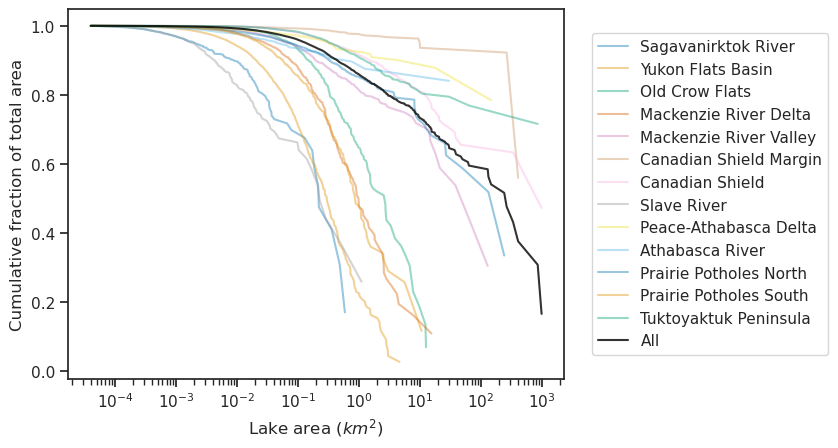

In [22]:
## Cumulative histogram by value (lake area), not count

## colors
# rainbow_cycler = cycler
sns.set_palette("colorblind",len(regions) ) # colors from https://stackoverflow.com/a/46152327/7690975 Other option is: `from cycler import cycler; `# ax.set_prop_cycle(rainbow_cycler), plt(... prop_cycle=rainbow_cycler, )

## plot
fig, ax = plt.subplots() # figsize=(5,3)
for region in regions[:-1]:
    plotECDFByValue(gdf_cir_lsd.query('Region == @region').Area, ax=ax, alpha=0.4, label=region)

## repeat for all
plotECDFByValue(gdf_cir_lsd.Area, ax=ax, alpha=0.8, color='black', label='All')
ax.legend(loc= 'center left', bbox_to_anchor=(1.04, 0.5)) # legend on right (see https://stackoverflow.com/a/43439132/7690975)

### Intro chapter figure

In [23]:
lsd = LSD(gdf_cir_lsd, area_var='Area', name='cir') # region_var='Region4', 
lsd['Name'] = 'cir'
lsd['Region'] = 'cir'
lsd.head()

,index,Area_km2,Region,geometry,Name
0,0,0.011819,cir,"POLYGON ((-680953.719 1387817.517, -680953.420...",cir
1,1,0.006978,cir,"POLYGON ((-681991.719 1387821.517, -681991.402...",cir
2,2,0.259890,cir,"POLYGON ((-681504.361 1387932.796, -681503.668...",cir
3,3,0.001193,cir,"POLYGON ((-680021.532 1387963.352, -680021.908...",cir
4,4,0.001669,cir,"POLYGON ((-681108.187 1388031.354, -681108.719...",cir


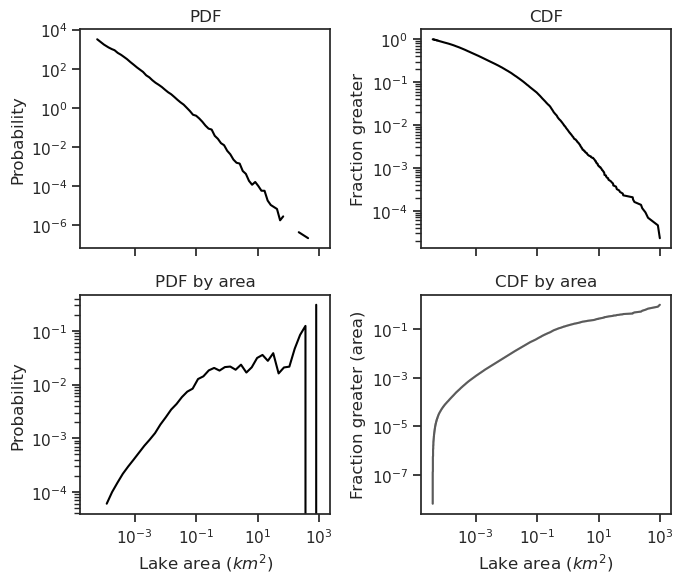

In [43]:
## Generate panel plot showing effects of PDF, CDF, Area-ECDF and binning
## fmt
fig, axs = plt.subplots(2,2, sharex=True, figsize=(7,6))
c='blue'
def set_black(ax):
    line = ax.get_lines()[0]
    line.set_color('black')
## PDF by count
ax=axs[0,0]
powerlaw.plot_pdf(lsd.Area_km2, ax=ax, color=c, label='All')
# ax.legend(loc= 'center left', bbox_to_anchor=(1.04, 0.5)) # legend on right (see https://stackoverflow.com/a/43439132/7690975)
ax.set_ylabel('Probability')
# ax.set_xlabel('Lake area')
ax.set_title('PDF')

## CDF by count
ax=axs[0,1]
powerlaw.plot_cdf(lsd.Area_km2, survival=True, ax=ax, color=c, label='All')
# ax.legend(loc= 'center left', bbox_to_anchor=(1.04, 0.5)) # legend on right (see https://stackoverflow.com/a/43439132/7690975)
ax.set_ylabel('Fraction greater')
# ax.set_xlabel('Lake area')
ax.set_title('CDF')

## PDF by area
ax=axs[1,0]
# lsd.plot_lsd(ax=ax, cdf=True, plotLegend=False)
# plotEPDFByValue(lsd.Area_km2, ax=ax)
binned = BinnedLSD(lsd, 0.0001, lsd.Area_km2.max(), compute_ci_lsd=False, normalize=False, nbins=40) # compute_ci_lsd=False will disable plotting CI.
binned.plot(as_lineplot=True, ax=ax)
ax.set_yscale('log')
ax.set_ylabel('Probability')
ax.set_xlabel('Lake area ($km^2$)')
ax.set_title('PDF by area')

## CDF by area
ax=axs[1,1]
lsd.plot_lsd(ax=ax, groupby_name=False, plotLegend=False, reverse=False)
ax.set_ylabel('Fraction greater (area)')
ax.set_yscale('log')
ax.set_title('CDF by area')

## fmt
fig.set_tight_layout(True)
for ax in axs.flatten():
    set_black(ax)

IndexError: list index out of range

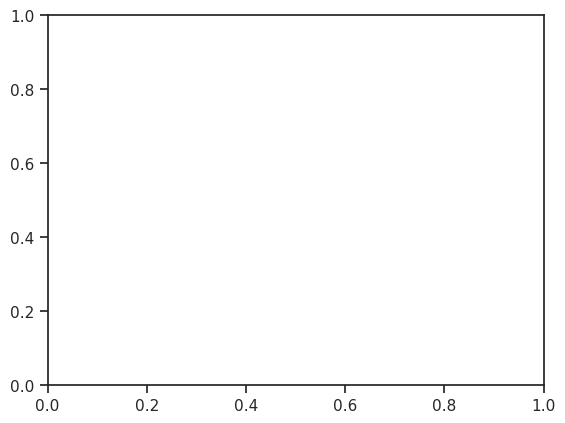

In [32]:
plt.gca().get_lines()[0]

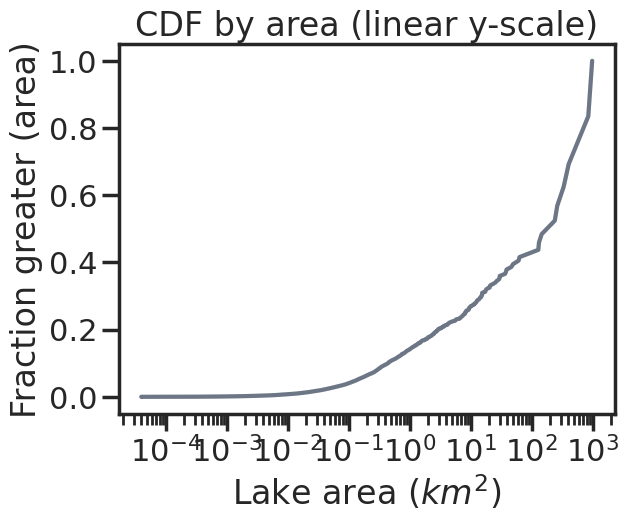

In [43]:
## CDF by area
sns.set(context='poster', style='ticks')
fig, ax = plt.subplots()
lsd.plot_lsd(ax=ax, groupby_name=False, plotLegend=False, reverse=False)
ax.set_ylabel('Fraction greater (area)')
# ax.set_yscale('log')
ax.set_title('CDF by area (linear y-scale)')
sns.set(context='notebook', style='ticks', font='Ariel')

# Calculate means and uncertainties for pond percentage from BAWLD

In [8]:
df_cir_rec

,Region_ID,Lake_area,stat,A_0.001,A_0.001_cor,A_0.01_cor,A_0.01,A_g100m,A_g1,PeRL_pnd_f,HL_pnd_f_4,HL_pnd_r_4,HL_pnd_r_3,HL_pnd_r_2
Region,,,,,,,,,,,,,,
Sagavanirktok River,2,3.468144,NaN,3.031203,3.031203,10.395833,10.395833,99.765595,0.0,10.185303,32.280063,47.667000,43.527349,32.626669
Yukon Flats Basin,3,178.651695,NaN,0.770614,0.99283,7.522919,5.839131,99.957466,22.382112,7.472215,37.126247,59.048881,57.556135,47.164407
Old Crow Flats,4,184.341128,NaN,0.06962,0.195526,1.837864,0.654397,99.995539,64.393612,1.825564,19.115591,23.633221,23.406948,21.376218
Mackenzie River Delta,5,142.371405,NaN,0.208666,0.396733,3.93086,2.067478,99.98745,47.403939,3.907932,22.986725,29.847743,29.363461,24.773382
Mackenzie River Valley,6,423.789104,NaN,0.163054,0.863484,6.227916,1.176034,99.986482,81.116737,6.160738,31.851304,46.737951,45.575106,37.697809
Canadian Shield Margin,7,724.885218,NaN,0.031646,1.33229,8.305,0.197271,99.99848,97.624667,8.246269,32.457055,48.053952,46.175011,35.845026
Canadian Shield,8,2082.631846,NaN,0.020982,0.247682,2.25814,0.191295,99.998384,91.528632,2.239487,23.767069,31.176905,30.876975,28.239215
Slave River,9,4.248273,NaN,3.07542,4.147409,23.358883,17.321269,99.744519,25.847187,23.093916,48.481453,94.104852,86.697767,49.278441
Peace-Athabasca Delta,10,186.61657,NaN,0.215694,2.832858,13.606928,1.03603,99.979017,92.386008,13.368182,37.795028,60.758854,56.636452,39.268317


In [8]:
def weightedStd(x, w):
    '''Computes standard deviation of values given as group means x, with weights w'''
    return np.sqrt((np.average((x-np.average(x, weights=w, axis=0))**2, weights=w, axis=0)).astype('float'))

## Test
# weightedStd(df_cir_rec.drop(index='All')['HL_pnd_r_2'], df_cir_rec.drop(index='All')['Lake_area'])
# weightedStd(df_cir_rec.drop(index='All')[ratio_cols], df_cir_rec.drop(index='All')['Lake_area'])

In [9]:
## Lookup table with ratios for extrapolation
# ratio_table = {
#     'HL_pnd_r_4': df_cir_rec.loc[ 'All', 'HL_pnd_r_4'],
#     'HL_pnd_r_3': df_cir_rec.loc[ 'All', 'HL_pnd_r_3'],
#     'HL_pnd_r_2': df_cir_rec.loc[ 'All', 'HL_pnd_r_2']
#     }
ratio_cols = ['HL_pnd_r_4', 'HL_pnd_r_3', 'HL_pnd_r_2']
ratio_table = pd.DataFrame({
    'All': df_cir_rec.loc['All', 'HL_pnd_r_4':'HL_pnd_r_2'],
    'Std': weightedStd(df_cir_rec.drop(index='All')[ratio_cols], df_cir_rec.drop(index='All')['Lake_area']), # [:, 'HL_pnd_r_4':'HL_pnd_r_2']
    'Std_unwt': df_cir_rec.drop(index='All')[ratio_cols].std(), # unweighted std dev (dont use)
    'Quant5': df_cir_rec.drop(index='All')[ratio_cols].quantile(0.05),
    'Quant95': df_cir_rec.drop(index='All')[ratio_cols].quantile(0.95)}) 

## Pre-add/subt to get upper and lower values based on std, for simplicity and thrift later on
ratio_table['Lower'] = ratio_table.All - ratio_table.Std
ratio_table['Upper'] = ratio_table.All + ratio_table.Std
ratio_table

,All,Std,Std_unwt,Quant5,Quant95,Lower,Upper
HL_pnd_r_4,39.865731,15.252170,27.423626,23.446645,103.182303,24.613561,55.117901
HL_pnd_r_3,38.777844,13.905687,24.606605,23.245031,94.895595,24.872157,52.683531
HL_pnd_r_2,32.451407,9.067662,15.149321,21.101484,60.640909,23.383745,41.519069


In [16]:
## Load grid and lake gdfs
gdf = pyogrio.read_dataframe(gdf_bawld_pth, read_geometry=True, use_arrow=True) # grid cells
df = pyogrio.read_dataframe(gdf_HL_jn_pth, columns=['BAWLDCell_', 'Shp_Area', 'BAWLDLong', 'BAWLDLat', '0-5', '5-50', '50-95','95-100'], read_geometry=False, use_arrow=True) # lakes (load as df to save mem)
print(df.head(2))
print(gdf.head(2))

        0-5      5-50      50-95     95-100  Shp_Area  BAWLDCell_  BAWLDLong  \
0  0.092034  0.071082  57.810849  42.026024  30450.64       11887    -122.25   
1  0.232737  0.198573   4.089538  95.479152  26734.29        7387    -113.25   

   BAWLDLat  
0     65.75  
1     61.75  
   Cell_ID    Long    Lat  Area_Pct      Shp_Area  GLA    ROC    TUN    BOR  \
0     7265  165.75  61.25     100.0  1.495458e+09  0.0  35.26  48.78  14.92   
1    14494   61.25  67.75     100.0  1.178664e+09  0.0   0.00  64.31   0.00   

     WET  ...  RIV_L  RIV_H  LAR_L  LAR_H  SRR_L  SRR_H  SRP_L  SRP_H  \
0   0.80  ...   0.09   0.24    0.0    0.0   0.00   0.05   0.23   0.39   
1  32.04  ...   0.14   0.38    0.0    0.0   0.01   0.28   0.00   0.12   

   WETSCAPE                                           geometry  
0        11  POLYGON ((774650.577 3106953.763, 801734.023 3...  
1         1  POLYGON ((2193307.808 -1190868.976, 2182832.13...  

[2 rows x 73 columns]


In [17]:
## Info
df.head(1)
# gdf.columns
!ogrinfo -al -so {gdf_HL_jn_pth}

INFO: Open of `/mnt/g/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.shp'
      using driver `ESRI Shapefile' successful.

Layer name: HL_zStats_Oc_binned_jnBAWLD
Metadata:
  DBF_DATE_LAST_UPDATE=2023-02-08
Geometry: Polygon
Feature Count: 1111864
Extent: (-180.000000, 45.004278) - (180.000000, 83.575951)
Layer SRS WKT:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Hylak_id: Integer64 (18.0)
0-5: Real (24.15)
5-50: Real (24.15)
50-95: Real (24.15)
95-100: Real (24.15)
Class_sum: Real (24.15)
Shp_Area: Real (13.2)
BAWLDCell

In [18]:
# Loop over grid cells (TODO: rewrite as a map or map_async)
for i in tqdm(range(len(gdf))): # 10 # len(gdf)
    ## Select only lakes in cell (based on pour point)
    cell_id = gdf.loc[i, 'Cell_ID'] # called BAWLD_Cell in df
    df_tmp = df.query(f'BAWLDCell_==@cell_id')

    ## compute area stats:
    ## Occurence stats
    gdf.loc[i, 'HL_area'] = df_tmp.Shp_Area.sum() # all HL-observable lakes
    gdf.loc[i, '0_5_area'] = np.nansum(df_tmp['0-5']/100 * df_tmp.Shp_Area) # Total area in an occurence bin
    gdf.loc[i, '5_50_area'] = np.nansum(df_tmp['5-50']/100 * df_tmp.Shp_Area) # Total area in an occurence bin 
    gdf.loc[i, '50_95_area'] = np.nansum(df_tmp['50-95']/100 * df_tmp.Shp_Area) # Total area in an occurence bin
    gdf.loc[i, '95_100_area'] = np.nansum(df_tmp['95-100']/100 * df_tmp.Shp_Area) # Total area in an occurence bin
    
    ## Occ stats normalized by total lake area
    if gdf.loc[i, 'HL_area'] > 0:
        gdf.loc[i, '0_5_per'] = gdf.loc[i, '0_5_area'] / gdf.loc[i, 'HL_area'] * 100
        gdf.loc[i, '5_50_per'] = gdf.loc[i, '5_50_area'] / gdf.loc[i, 'HL_area'] * 100
        gdf.loc[i, '50_95_per'] = gdf.loc[i, '50_95_area'] / gdf.loc[i, 'HL_area'] * 100
        gdf.loc[i, '95_100_per'] = gdf.loc[i, '95_100_area'] / gdf.loc[i, 'HL_area'] * 100

    ## extrapolations
    gdf.loc[i, 'Ppnd_area'] = df_tmp.query('(Shp_Area >= 0.0001) and  (Shp_Area < 0.01)').Shp_Area.sum() # perl ponds (will always be 0 for HL)
    gdf.loc[i, 'Plk_area'] = df_tmp.query('(Shp_Area >= 0.01) and  (Shp_Area < 1)').Shp_Area.sum() # perl lakes (not ponds)
    gdf.loc[i, 'Mid_lk_area'] = df_tmp.query('(Shp_Area >= 0.1) and  (Shp_Area < 1)').Shp_Area.sum() # Mid lakes (if I used 0.3 cutoff, I could include all CIR sites) to use for extrapolation
    gdf.loc[i, 'Lg_lk_area'] = df_tmp.query('(Shp_Area >= 1)').Shp_Area.sum() # Large lakes (add to extrapolation)
    gdf.loc[i, 'Extrap4'] = (1 + ratio_table.loc['HL_pnd_r_4', 'All'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area'] # Hpond extrap 10 e-4
    gdf.loc[i, 'Extrap4_l'] = (1 + ratio_table.loc['HL_pnd_r_4', 'Lower'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Extrap4_u'] = (1 + ratio_table.loc['HL_pnd_r_4', 'Upper'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Extrap3'] = (1 + ratio_table.loc['HL_pnd_r_3', 'All'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Extrap3_l'] = (1 + ratio_table.loc['HL_pnd_r_3', 'Lower'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Extrap3_u'] = (1 + ratio_table.loc['HL_pnd_r_3', 'Upper'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Extrap2'] = (1 + ratio_table.loc['HL_pnd_r_2', 'All'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Extrap2_l'] = (1 + ratio_table.loc['HL_pnd_r_2', 'Lower'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Extrap2_u'] = (1 + ratio_table.loc['HL_pnd_r_2', 'Upper'] / 100) * gdf.loc[i, 'Mid_lk_area'] + gdf.loc[i, 'Lg_lk_area']
    gdf.loc[i, 'Meg_lk_area'] = df_tmp.query('(Shp_Area >= 5000)').Shp_Area.sum() # Mega lakes (often subtracted from upscaling)

gdf.head()

100%|██████████| 23469/23469 [05:38<00:00, 69.32it/s]


,Cell_ID,Long,Lat,Area_Pct,Shp_Area,GLA,ROC,TUN,BOR,WET,...,Extrap3_l,Extrap3_u,Extrap2,Extrap2_l,Extrap2_u,Meg_lk_area,0_5_per,5_50_per,50_95_per,95_100_per
0,7265,165.75,61.25,100.00,1.495458e+09,0.0,35.26,48.78,14.92,0.80,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN
1,14494,61.25,67.75,100.00,1.178664e+09,0.0,0.00,64.31,0.00,32.04,...,9.394003,9.610932,9.453121,9.382393,9.523849,0.0,4.613735,3.272044,91.882694,0.231527
2,3598,51.25,57.25,42.39,7.103697e+08,0.0,0.00,0.00,91.04,8.81,...,0.412078,0.503856,0.437090,0.407166,0.467013,0.0,38.930269,40.325524,20.744207,0.000000
3,4863,122.25,58.75,100.00,1.612116e+09,0.0,0.00,0.00,96.13,3.72,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN
4,19124,-99.25,73.25,100.00,8.978315e+08,0.0,31.62,63.32,0.00,2.96,...,19.801121,21.188908,20.179325,19.726849,20.631802,0.0,3.976465,0.601010,88.852357,6.569278


In [13]:
## INfo on result
df[['50-95', 'Shp_Area']] # km2 for HL
gdf[['5_50_area', '50_95_area', '50_95_per', 'HL_area']]
gdf.loc[20:25,['5_50_area', '50_95_area', '50_95_per', 'HL_area', 'Cell_ID']]

,5_50_area,50_95_area,50_95_per,HL_area,Cell_ID
20,14.531896,102.464825,26.721125,383.46,2199
21,16.803188,99.333975,66.591121,149.17,276
22,0.000000,0.000000,NaN,0.00,23427
23,0.000000,0.000000,NaN,0.00,2077
24,0.000000,0.000000,NaN,0.00,8180
25,0.573379,12.803729,87.337853,14.66,18040


In [19]:
## Write out
gdf.to_csv(area_extrap_pth)
print(f'Wrote file: {area_extrap_pth}')

Wrote file: /mnt/g/Ch4/Area_extrapolations/v3/HL_subBAWLD_extrap.csv


In [20]:
## Write out as shapefile
# pyogrio.write_dataframe(gdf, area_extrap_pth.replace('.csv','.shp')) # Why so slow...150 min??
area_extrap_pth_shp = area_extrap_pth.replace('.csv','.shp')
gdf.to_file(area_extrap_pth_shp)
print(f'Wrote file: {area_extrap_pth_shp}')

/tmp/ipykernel_460/4027235234.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(area_extrap_pth_shp)


Wrote file: /mnt/g/Ch4/Area_extrapolations/v3/HL_subBAWLD_extrap.shp


In [21]:
## Skip analysis and load
# gdf = pd.read_csv(area_extrap_pth)
# !csv {area_extrap_pth}
!head -n 2 {area_extrap_pth} | column -s, -t 

Cell_ID  Long  Lat     Area_Pct  Shp_Area  GLA           ROC  TUN    BOR    WET    PEB  WTU   MAR   BOG   FEN  LAK   LAL  MPL  MYL  MGL  SPL  SYL  SGL  RIV  LAR   SRR  SRP  GLA_L  GLA_H  ROC_L  ROC_H  TUN_L  TUN_H  BOR_L  BOR_H  WET_L  WET_H  PEB_L  PEB_H  WTU_L  WTU_H  MAR_L  MAR_H  BOG_L  BOG_H  FEN_L  FEN_H  LAK_L  LAK_H  LAL_L  LAL_H  MPL_L  MPL_H  MYL_L  MYL_H  MGL_L  MGL_H  SPL_L  SPL_H  SYL_L  SYL_H  SGL_L  SGL_H  RIV_L  RIV_H  LAR_L  LAR_H  SRR_L  SRR_H  SRP_L  SRP_H  WETSCAPE  geometry  HL_area                                          0_5_area                               5_50_area                        50_95_area                             95_100_area                               Ppnd_area  Plk_area  Mid_lk_area  Lg_lk_area  Extrap4  Extrap4_l  Extrap4_u  Extrap3  Extrap3_l  Extrap3_u  Extrap2  Extrap2_l  Extrap2_u  Meg_lk_area  0_5_per  5_50_per  50_95_per  95_100_per
0        7265  165.75  61.25     100.0     1495458177.0  0.0  35.26  48.78  14.92  0.8  0.48  0.09  0.05

In [19]:
## Check
gdf.iloc[250:260,:]
gdf.Hpnd_extrap4.sum()
gdf.HL_area.sum()

1177983.37

/tmp/ipykernel_23509/939897170.py:3: FutureWarning: The default value of numeric_only in GeoDataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sums = gdf.sum()


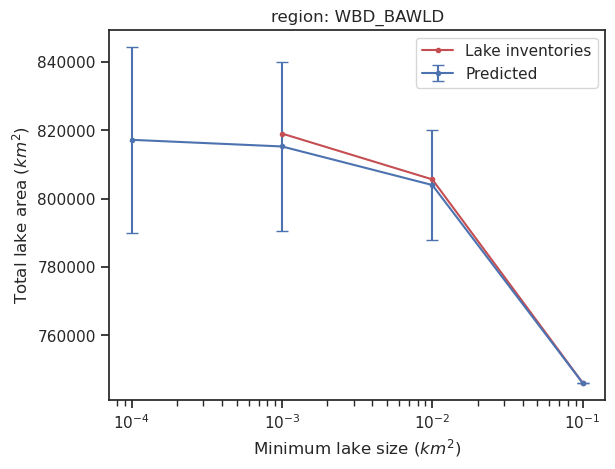

In [112]:
## Plot total area as function of extrapolated min. size

sums = gdf.sum()
plt.errorbar([0.1, 0.01, 0.001, 0.0001], [sums.HL_area, sums.Hpnd_extrap2, sums.Hpnd_extrap3, sums.Hpnd_extrap4],
    yerr=[0, sums.Hpnd_extrap2-sums.Hpnd_extrap2_l, sums.Hpnd_extrap3-sums.Hpnd_extrap3_l, sums.Hpnd_extrap4-sums.Hpnd_extrap4_l],
    capsize=4, fmt='.-b', label='Predicted')
plt.plot([0.1, 0.01, 0.001], [746137.7599999998, 805675.0937146356, 819091.9657548245], '.-r', label='Lake inventories') # Paste summed values from lake databases here
plt.xscale('log')
plt.xlabel('Minimum lake size ($km^2$)')
plt.ylabel('Total lake area ($km^2$)')
plt.title(f'region: {roi_region}')
plt.legend()

TODO: 
* make equivalence to hl_pond_frac_cir x
* [try using numba to accelerate?]
* save 1 vs. 0.3 cutoff as var 
* add std or CI x
* write out x
* find a way to relate to flux estimates

# SCRAP

In [ ]:
## V2 customize
import dask.bag as db
import dask.dataframe as dd
from glob import glob
import dask

# Define the file pattern
file_pattern = '/mnt/f/PeRL/PeRL_waterbodymaps/waterbodies/arg00120110829_k2_nplaea.shp'

# Create an instance of the custom loader class
# loader = LSD(gdf_cir_lsd) # dummy

# Create a Dask Bag of file paths that match the file pattern
files = db.from_sequence(sorted(glob(file_pattern)))

# Apply the custom loading method to each file path in parallel, creating a list of delayed Pandas DataFrames
dfs = [dask.delayed(LSD.from_shapefile)(filename, 'AREA', None, None, os.path.basename(file_pattern).replace('.shp','')) for filename in files]

# Create a Dask DataFrame from the list of delayed Pandas DataFrames
df = dd.from_delayed(dfs)

df.head(2)


ValueError: Metadata mismatch found in `from_delayed`.

Expected partition of type `pandas.core.frame.DataFrame` but got `__main__.LSD`

In [ ]:
## V3 use geopandas loader (This works, but doesn't retain region name from filename...)
import dask.bag as db
import dask.dataframe as dd
from glob import glob
import dask

# Define the file pattern
file_pattern = '/mnt/f/PeRL/PeRL_waterbodymaps/waterbodies/y*.shp'

# Create an instance of the custom loader class
# loader = LSD(gdf_cir_lsd) # dummy

# Create a Dask Bag of file paths that match the file pattern
files = db.from_sequence(sorted(glob(file_pattern)))

# Apply the custom loading method to each file path in parallel, creating a list of delayed Pandas DataFrames
dfs = [dask.delayed(gpd.read_file)(filename, None, None, None, 'pyogrio') for filename in files]

# Create a Dask DataFrame from the list of delayed Pandas DataFrames
df = dd.from_delayed(dfs)

df.head(2)


,AREA,PERIMETER,geometry
0,4578.227539,470.074761,"POLYGON ((2329914.760 1969331.283, 2329921.269..."
1,1726.216309,209.286109,"POLYGON ((2329894.714 1969348.177, 2329887.171..."
